In [39]:
!nvidia-smi

Sun Aug 14 15:39:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   55C    P8    19W / 210W |    972MiB /  8192MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 資料讀取與前處理

In [57]:
###### 資料讀取 實際測試時此區改為讀取攔截之封包資料
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

csv_files = []
for dirname, _, filenames in os.walk('MachineLearningCSV/MachineLearningCVE'):
    for filename in filenames:
        csv_file = os.path.join(dirname, filename)
        print(os.path.join(dirname, filename))
        csv_files.append(csv_file)

# df = pd.concat([pd.read_csv(file) for file in csv_files[:8]], ignore_index=True)
df = pd.read_csv("MachineLearningCSV/MachineLearningCVE/week_2.csv",index_col = 0)

df.columns = df.columns.str.strip()
print("original length of df:", len(df))
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print("after droping null values, the length of df:", len(df))

MachineLearningCSV/MachineLearningCVE\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
MachineLearningCSV/MachineLearningCVE\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
MachineLearningCSV/MachineLearningCVE\Friday-WorkingHours-Morning.pcap_ISCX.csv
MachineLearningCSV/MachineLearningCVE\Monday-WorkingHours.pcap_ISCX.csv
MachineLearningCSV/MachineLearningCVE\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
MachineLearningCSV/MachineLearningCVE\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
MachineLearningCSV/MachineLearningCVE\Tuesday-WorkingHours.pcap_ISCX.csv
MachineLearningCSV/MachineLearningCVE\Wednesday-workingHours.pcap_ISCX.csv
MachineLearningCSV/MachineLearningCVE\week.csv
MachineLearningCSV/MachineLearningCVE\week_2.csv
original length of df: 2830743
after droping null values, the length of df: 2827876


In [58]:
###### 針對標籤之處理，實際測試攔截封包資料時可拿掉
df_experiment = df.copy()
df_experiment.Label.replace("Web.*", "Web Attack", regex=True, inplace=True)
df_experiment.Label.replace(r'.*Patator$', "Brute Force", regex=True,inplace=True)
df_experiment.Label.replace(["DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest", "DoS slowloris"], "DoS", inplace=True)

class_attack = ['PortScan', 'Web Attack', 'Brute Force', 'DDoS', 'Bot','Infiltration', 'DoS', 'Heartbleed']
df_experiment.Label.replace(class_attack, value='attack', inplace=True)
df_experiment.Label.value_counts()

BENIGN    2271320
attack     556556
Name: Label, dtype: int64

In [69]:
# data split and preprocess
from sklearn.model_selection import train_test_split
import joblib

std_scaler,mm_scaler,le = joblib.load("model/std_mm_le_new.save")

y = df_experiment.Label
X = df_experiment.drop(columns='Label')
labels = y.unique()

X = std_scaler.transform(X)

classes = y.nunique()
print(X.shape)
print("number of labels:", classes)
print("instances per label\n", y.value_counts())
print("labels:", labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

print("after spliting the data:\n")
print("training data length:", len(X_train))
print("test data length:", len(X_test))

X_train = mm_scaler.transform(X_train)
X_test = mm_scaler.transform(X_test)

print("after MinMaxScaler")
print(X_train.shape)

#標籤編碼 可不跑
# y_train = le.transform(y_train)
# y_test = le.transform(y_test)

In [60]:
###### Random Forest
import joblib

rng = np.random.RandomState(42)

model = joblib.load("model/pkl/new_randomForest_32.pkl")
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(y_train_pred)
print(y_train_pred.shape)
print(y_test_pred)
print(y_test_pred.shape)

print("percentage of Anomaly:", (list(y_test_pred).count(1)/y_test_pred.shape[0])*100)
print("percentage of Legit:",(list(y_test_pred).count(0)/y_test_pred.shape[0])*100)

[0 0 0 ... 1 0 1]
(2120907,)
[0 0 1 ... 0 0 0]
(706969,)
percentage of Anomaly: 19.7059559895837
percentage of Legit: 80.2940440104163


In [68]:
y_train_pred


array([0, 0, 0, ..., 1, 0, 1])

In [70]:
y_train

array([0, 0, 0, ..., 1, 0, 1])

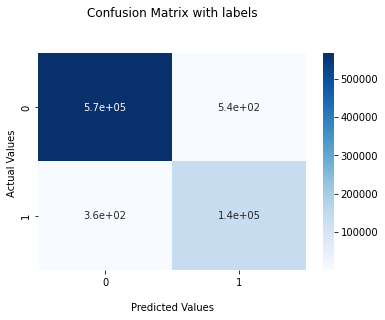

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cf_matrix.ravel()
cf_matrix

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

plt.show()
# plt.savefig('img/new_confusion_matrix_32.png')

In [17]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_train, y_train_pred)
tn, fp, fn, tp = cf_matrix.ravel()
cf_matrix

array([[1702181,    1309],
       [    596,  416821]], dtype=int64)

# Test for CICFLOWMETER Data

In [88]:
###### 資料讀取 實際測試時此區改為讀取攔截之封包資料
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

df = pd.read_csv("MachineLearningCSV/testflows.csv")

df.columns = df.columns.str.strip()
print("original length of df:", len(df))
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print("after droping null values, the length of df:", len(df))

original length of df: 975
after droping null values, the length of df: 975


In [89]:
df = df.drop(["src_ip" , "dst_ip", "src_port", "src_mac", "dst_mac", "protocol", "timestamp"], axis = 1)

In [90]:
df

,dst_port,flow_duration,flow_byts_s,flow_pkts_s,fwd_pkts_s,bwd_pkts_s,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,...,bwd_pkts_b_avg,fwd_blk_rate_avg,bwd_blk_rate_avg,fwd_seg_size_avg,bwd_seg_size_avg,cwe_flag_count,subflow_fwd_pkts,subflow_bwd_pkts,subflow_fwd_byts,subflow_bwd_byts
0,67,0.0,0.000000e+00,0.000000,0.000000,0.000000,1,0,379,0,...,0.0,0.0,0.000000e+00,379.000000,0.000000,0,1,0,379,0
1,68,0.0,0.000000e+00,0.000000,0.000000,0.000000,1,0,342,0,...,0.0,0.0,0.000000e+00,342.000000,0.000000,0,1,0,342,0
2,5355,349616.0,4.290421e+02,5.720562,5.720562,0.000000,2,0,150,0,...,0.0,0.0,0.000000e+00,75.000000,0.000000,0,2,0,150,0
3,53,201.0,1.611940e+06,9950.248756,4975.124378,4975.124378,1,1,128,196,...,0.0,0.0,0.000000e+00,128.000000,196.000000,0,1,1,128,196
4,53,196.0,1.020408e+06,10204.081633,5102.040816,5102.040816,1,1,92,108,...,0.0,0.0,0.000000e+00,92.000000,108.000000,0,1,1,92,108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,587,2166245.0,3.664867e+03,14.310477,5.539540,8.770938,12,19,1174,6765,...,4.0,0.0,1.187766e+06,97.833333,356.052632,0,12,19,1174,6765
971,465,1881400.0,2.968534e+03,11.693420,4.783672,6.909748,9,13,986,4599,...,0.0,0.0,0.000000e+00,109.555556,353.769231,0,9,13,986,4599
972,465,1016955.0,1.297993e+02,1.966655,1.966655,0.000000,2,0,132,0,...,0.0,0.0,0.000000e+00,66.000000,0.000000,0,2,0,132,0
973,25,1898370.0,2.729710e+03,9.481819,3.687374,5.794445,7,11,738,4444,...,0.0,0.0,0.000000e+00,105.428571,404.000000,0,7,11,738,4444


In [91]:
# data split and preprocess
from sklearn.model_selection import train_test_split
import joblib

std_scaler,mm_scaler,le = joblib.load("model/std_mm_le_new.save")

X = df

X = std_scaler.transform(X)

print("after StandardScaler")
print(X.shape)

X = mm_scaler.transform(X)

print("after MinMaxScaler")
print(X.shape)

#標籤編碼 可不跑
# y_train = le.transform(y_train)
# y_test = le.transform(y_test)

after StandardScaler
(975, 77)
after MinMaxScaler
(975, 77)


In [92]:
###### Random Forest
import joblib

rng = np.random.RandomState(42)

model = joblib.load("model/pkl/new_randomForest_32.pkl")
X_pred = model.predict(X)

print(X_pred)
print(X_pred.shape)

print("percentage of Anomaly:", (list(X_pred).count(1)/X_pred.shape[0])*100)
print("percentage of Legit:",(list(X_pred).count(0)/X_pred.shape[0])*100)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [93]:
model

RandomForestClassifier(n_estimators=32,
                       random_state=RandomState(MT19937) at 0x203BD50EE18)

In [94]:
estimator = model.estimators_[5]

In [95]:
estimator

DecisionTreeClassifier(max_features='auto', random_state=1201263687)

[Text(268.83181099785094, 214.5016216216216, 'X[18] <= 0.175\ngini = 0.316\nsamples = 1340617\nvalue = [1704331, 416576]'),
 Text(210.19776941830855, 208.62486486486486, 'X[53] <= 0.002\ngini = 0.218\nsamples = 1206427\nvalue = [1670870, 238073]'),
 Text(139.40366413265093, 202.7481081081081, 'X[6] <= 0.0\ngini = 0.486\nsamples = 334748\nvalue = [309768, 220231]'),
 Text(75.69771692977604, 196.87135135135134, 'X[53] <= 0.001\ngini = 0.467\nsamples = 299509\nvalue = [297687, 176597]'),
 Text(47.19472402945593, 190.9945945945946, 'X[50] <= 0.5\ngini = 0.319\nsamples = 162347\nvalue = [205988, 51189]'),
 Text(35.50383212983485, 185.11783783783784, 'X[7] <= 0.0\ngini = 0.445\nsamples = 92126\nvalue = [97231, 48716]'),
 Text(29.71239293629799, 179.24108108108106, 'X[3] <= 0.354\ngini = 0.491\nsamples = 67766\nvalue = [61032, 46274]'),
 Text(26.641338385643813, 173.36432432432431, 'X[62] <= 0.065\ngini = 0.371\nsamples = 33020\nvalue = [39533, 12926]'),
 Text(22.031166082791163, 167.48756756

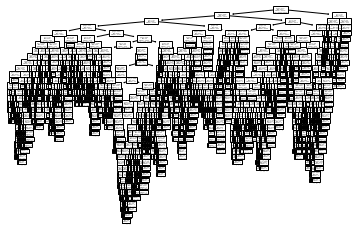

In [102]:
from sklearn import tree
tree.plot_tree(estimator)